# Seattle Airbnbn Listings Analysis_CRISP-DM
- __Author: William Wang__
- __Created: 12/17/2020__

## Context
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA. This project is going to analyse the Seattle Airbnb Listings to see if any insight from data could help Airbnb optimize the business.

In this project, __CRISP-DM (Cross-Industry Standard Process for Data Mining)__ will be applied to better frame the problem and get the insight from data analysis.

- __CRISP-DM__:
    * Business Understanding
    * Data Understanding
    * Data Preparation
    * Modeling
    * Evaluation
    * Deployment


## To analyse:
This project will analyse the Seattle Airbnbn Listings as following:

- Which communities/neighborhood/areas are most welcome in Seattle?
    * Explore the distrbution of listings, and it might be opportunities for Airbnb to get insight of which neighbourhood and areas are more likely to host Airbnb
    
    
- Find the busiest times of the year to visit Seattle and by how much prices spike
    * For Airbnb, it'll be a loss if the available room can't satisfy the user demand within busy season
    * Also, the scale of price increase will be helpful for business opportunities
    
    
- Verify that if there's a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle
    * Get an insight on how the host and vistors change in period
    
    
- Describe the vibe of each Seattle neighborhood using listing descriptions, What factor relates to higher guests review most?
    * Explore if there's any common characteristics among Seattle neighborhood, and it might be opportunities for Airbnb to get insight of what kind of neighbourhood are more likely to host Airbnb
    * Probably also look at if there's any preference on neighbourhood among visitors

In [561]:
import pandas as pd
import numpy as np
from numpy import nansum, nanmax,nanmean
import re
import nltk 
import matplotlib.pyplot as plt
from datetime import date
from datetime import timedelta
from datetime import datetime
import folium
import json
from collections import Counter
import plotly.graph_objects as go
import datapane as dp
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
import chart_studio
import chart_studio.plotly as py
pd.set_option('display.max_rows', 100)

# Data understanding and preparation

First, load in dataset and have a cursory overview to understand the data.

Three data sets are provided:
- listings: including full descriptions and average review score
- calendar: including listing id and the price and availability for that day
- reviews: including unique id for each reviewer and detailed comments

In [512]:
calendar = pd.read_csv(r'calendar.csv')
listings = pd.read_csv(r'listings.csv')
reviews = pd.read_csv(r'reviews.csv')

In [515]:
sample = pd.DataFrame((listings.head(1).T).rename(columns={0:'sample'})).reset_index()
col_not_null_rate = pd.DataFrame(((~listings.isnull()).sum()/listings.shape[0])).rename(columns={0:'col_not_null_rate'}).reset_index()
dtype = pd.DataFrame(listings.dtypes).rename(columns={0:'dtype'}).reset_index()
stats = sample.merge(col_not_null_rate).merge(dtype).set_index('index')
stats.index.name = 'col'

In [516]:
stats

,sample,col_not_null_rate,dtype
col,,,
id,241032,1.000000,int64
listing_url,https://www.airbnb.com/rooms/241032,1.000000,object
scrape_id,20160104002432,1.000000,int64
last_scraped,2016-01-04,1.000000,object
name,Stylish Queen Anne Apartment,1.000000,object
summary,NaN,0.953641,object
space,Make your self at home in this charming one-be...,0.850969,object
description,Make your self at home in this charming one-be...,1.000000,object
experiences_offered,none,1.000000,object


In [517]:
listings['id'].nunique()

3818

In [518]:
listings['host_since'] = listings['host_since'].dropna().apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
listings['year'] = listings['host_since'].dt.year
listings['month'] = listings['host_since'].dt.month
listings['price'] = listings['price'].dropna().apply(lambda x:float(x.replace('$','').replace(',','')))
listings['zipcode'] = listings['zipcode'].dropna().apply(lambda x:x[-5:])
house_count = listings.groupby(['zipcode']).agg({'id':'count'}).rename(columns={'id':'house_count'}).reset_index()

reviews['date'] = reviews['date'].dropna().apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month

calendar['date'] = calendar['date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
calendar = calendar.sort_values('date')
calendar['month'] = calendar['date'].dt.month
calendar['week'] = calendar['date'].dt.week
calendar['weekday'] = calendar['date'].dt.weekday
calendar['price'] = calendar['price'].dropna().apply(lambda x:float(x.replace('$','').replace(',','')))

# Which communities/neighborhood/areas are most welcome in Seattle?


In [522]:
listings['neighbourhood_group_cleansed'] = listings['neighbourhood_group_cleansed'].fillna('Missing')
listings['zipcode'] = listings['zipcode'].fillna('Missing')
nb_avg = listings.groupby(['neighbourhood_group_cleansed','zipcode']).agg({"latitude":nanmean,"longitude":nanmean,"price":nanmean,"id":'count'}).\
rename(columns = {"latitude":"latitude_nb_avg","longitude":"longitude_nb_avg","id":'nb_house_count',"price":'nb_price_avg'}).reset_index()
listings = listings.merge(nb_avg,'left',on=['neighbourhood_group_cleansed','zipcode'])

In [523]:
with open(r'zip-codes.geojson','r') as jsonFile:
    zipgeo = json.load(jsonFile)
    
geozips = []
for i in range(len(zipgeo['features'])):
    if zipgeo['features'][i]['properties']['GEOID10'] in list(house_count['zipcode'].unique()):
        geozips.append(zipgeo['features'][i])
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips   

open(r'zip-codes-updated.json', "w").\
     write(json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')))

In [528]:
stats

,sample,col_not_null_rate,dtype
col,,,
id,241032,1.000000,int64
listing_url,https://www.airbnb.com/rooms/241032,1.000000,object
scrape_id,20160104002432,1.000000,int64
last_scraped,2016-01-04,1.000000,object
name,Stylish Queen Anne Apartment,1.000000,object
summary,NaN,0.953641,object
space,Make your self at home in this charming one-be...,0.850969,object
description,Make your self at home in this charming one-be...,1.000000,object
experiences_offered,none,1.000000,object


In [529]:
zipcodes_agg = listings[['zipcode','neighbourhood_group_cleansed','latitude_nb_avg','longitude_nb_avg','nb_house_count','nb_price_avg']]\
.drop_duplicates().reset_index().drop('index',axis=1)

In [530]:
zipcodes_agg['neighborhood_zipcode'] = zipcodes_agg['neighbourhood_group_cleansed'] + '(' + zipcodes_agg['zipcode'] + ')'

In [531]:
m = folium.Map(location=[47.608013, -122.335167], tiles='CartoDB positron', zoom_start=11,
                   detect_retina=True, control_scale=False)

choropleth = folium.Choropleth(
    geo_data=r'zip-codes-updated.json',
    name='choropleth',
    data=house_count,
    columns=['zipcode', 'house_count'],
    key_on='feature.properties.GEOID10',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='house count'
).add_to(m)

folium.LayerControl().add_to(m)
# Display Region Label
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['GEOID10'], labels=False)
)

for i in range(zipcodes_agg.shape[0]):
    location = [float(zipcodes_agg['latitude_nb_avg'][i]),
                float(zipcodes_agg['longitude_nb_avg'][i])]
    popup="""
          <i>Mean sales price: </i> <br> <b>${}</b> <br> 
          """.format(zipcodes_agg['nb_house_count'][i])
    tooltip = "Neighbourhood_Zipcode:{}<br> House count: {}<br> Average price: {}<br>".\
    format(zipcodes_agg["neighborhood_zipcode"][i], 
           zipcodes_agg['nb_house_count'][i],
           round(zipcodes_agg['nb_price_avg'][i],0))
    folium.Circle(
      location=location,
      popup=None,
      tooltip=tooltip,
      radius=int(zipcodes_agg['nb_house_count'][i]),
      color='#31cc93',
      fill=True,
      fill_color='#31cc93'
    ).add_to(m)

In [565]:
zipcodes_agg.sort_values('nb_house_count')

,zipcode,neighbourhood_group_cleansed,latitude_nb_avg,longitude_nb_avg,nb_house_count,nb_price_avg,neighborhood_zipcode
25,98119,Downtown,47.614586,-122.351533,1,125.000000,Downtown(98119)
37,98118,West Seattle,47.555541,-122.382754,1,75.000000,West Seattle(98118)
29,98144,Downtown,47.604798,-122.317382,1,68.000000,Downtown(98144)
28,Missing,Downtown,47.604879,-122.322308,1,65.000000,Downtown(Missing)
40,Missing,Interbay,47.661186,-122.385344,1,95.000000,Interbay(Missing)
17,Missing,Central Area,47.604754,-122.294383,1,55.000000,Central Area(Missing)
14,98103,University District,47.659933,-122.321442,1,45.000000,University District(98103)
10,98101,Cascade,47.629375,-122.339746,1,249.000000,Cascade(98101)
41,98104,Other neighborhoods,47.595772,-122.327316,1,150.000000,Other neighborhoods(98104)
66,98126,Other neighborhoods,47.588696,-122.380150,1,130.000000,Other neighborhoods(98126)


In [532]:
m

In [ ]:
dp.login(token=your_datapane_token)

# dataset = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
# locations = dataset[['location', 'iso_code']].sample(3) # Replace with you own locations to customize!
# df = dataset[dataset.iso_code.isin(locations.iso_code)]

# plot = alt.Chart(df).mark_area(opacity=0.4, stroke='black').encode(
#     x='date:T', y=alt.Y('new_cases_smoothed_per_million:Q', stack=None),
#     color=alt.Color('location:N', scale=alt.Scale(scheme='set1')), tooltip='location:N'
# ).interactive().properties(width='container')

# Create report
r = dp.Report(
    'Seattle Airbnb Community Distribution',
    f'_Built using data from [Kaggle](https://www.kaggle.com/airbnb/seattle/data) on {date.today()}_',
    dp.Plot(m),
#     dp.DataTable(zipcodes_agg),
)

# Publish
r.publish(name='Seattle Airbnb Community Distribution', open=True, 
          description=f'House count/Avg price in {", ".join(zipcodes_agg.neighbourhood_group_cleansed.unique())}')
                    

# What are the busiest times of the year to visit Seattle? By how much do prices spike?

In [536]:
# def chunks(l, n):
#     for i in range(0, len(l), n):
#         yield l[i:i+n]
        
# listing_id_lst = list(chunks(calendar['listing_id'].unique(), 100))

# calendar_lst = []
# cutoff = 7
# upper_bound = 500
# for idx1,listing_id  in enumerate(listing_id_lst):
#     calendar_new_price = pd.DataFrame(columns=['index', 'listing_id', 'date', 'available', 'price', 'month', 'week'])
#     for idx,id in enumerate(listing_id):
#         test = calendar[calendar['listing_id'] == id].reset_index()
#         not_null_list =test[~test['price'].isnull()].index
#         null_list = test[test['price'].isnull()].index
#         if ~test['price'].isnull().all():
#             for i in null_list:
#                 fr = min(list(map(lambda x:abs(x-i) if x<=i and abs(x-i)<=7 else upper_bound,not_null_list)))
#                 bk = min(list(map(lambda x:abs(x-i) if x>=i and abs(x-i)<=7 else upper_bound,not_null_list)))
#                 frbk = fr,bk
#                 if fr not in (0,upper_bound):
#                     fr_diff = i - fr
#                 else:
#                     fr_diff = i

#                 if bk not in (0,upper_bound):
#                     bk_diff = i + bk
#                 else:
#                     bk_diff = i

#                 if min(fr_diff,bk_diff) == upper_bound:
#                     closest = max(null_list)
#                 elif (fr_diff==i)&(bk_diff==i):
#                     closest = i
#                 else:
#                     closest = sorted(list(set([fr_diff,bk_diff])-set([i])))[frbk.index(min(fr,bk))]
#                 test.loc[i,'price'] = test.loc[closest,'price']

#         calendar_new_price = calendar_new_price.append(test)
#     calendar_lst.append(calendar_new_price)   
# calendar = pd.concat(calendar_lst)

In [539]:
calendar_price_count = calendar.groupby(['listing_id']).agg({'price':'nunique'}).rename(columns={'price':'price_count'}).reset_index()
calendar_mon_count = calendar.groupby(['week','available']).\
agg({'listing_id':'count','price':nanmean}).\
rename(columns = {'listing_id':'id_available_count_month',
                  'price':'mean_price'}).reset_index().\
merge(calendar.groupby(['week']).agg({'listing_id':'count'}).\
rename(columns = {'listing_id':'id_count_month'}).reset_index(),'left',on=['week']).\
merge(calendar[['month','week']].drop_duplicates('week'),'left',on=['week'])

In [540]:
calendar_mon_count['Percentage']=\
round(calendar_mon_count['id_available_count_month']/\
calendar_mon_count['id_count_month'],2)
calendar_mon_count['mean_price'] = round(calendar_mon_count['mean_price'])

In [541]:
calendar_mon_count['month-week'] = calendar_mon_count['month'].astype(str) + '-' + calendar_mon_count['week'].astype(str)
calendar_mon_ava_count = calendar_mon_count[calendar_mon_count['available']=='t'][['month-week', 'available','Percentage','mean_price']]
calendar_mon_notava_count = calendar_mon_count[calendar_mon_count['available']=='t'][['month-week', 'available','mean_price']]

In [542]:
# fig = plt.figure(figsize=(20, 10))
# host = fig.add_subplot(111)

# par1 = host.twinx()


# host.set_xlim(0, 51)
# host.set_ylim(min(calendar_mon_ava_count['Percentage'])-0.1
#               , max(calendar_mon_ava_count['Percentage'])+0.1)
# par1.set_ylim(min(calendar_mon_ava_count['mean_price'])-20, 
#               max(calendar_mon_ava_count['mean_price'])+20)

# host.set_xlabel("month-week", fontsize=20)
# host.set_ylabel("Available rate", fontsize=20)
# par1.set_ylabel("Mean price", fontsize=20)

# color1 = plt.cm.viridis(0)
# color2 = plt.cm.viridis(0.5)
# color3 = plt.cm.viridis(.9)

# p1, = host.plot(calendar_mon_ava_count['month-week'], 
#                 calendar_mon_ava_count['Percentage'], color=color1,
#                 label="Available rate")
# p2, = par1.plot(calendar_mon_ava_count['month-week'], 
#                 calendar_mon_ava_count['mean_price'], color=color2, 
#                 label="Mean price")


# lns = [p1, p2]
# host.legend(handles=lns, loc='best', fontsize=20)

# # right, left, top, bottom
# # par2.spines['right'].set_position(('outward', 60))      
# # no x-ticks                 
# # par2.xaxis.set_ticks([])
# # Sometimes handy, same for xaxis
# #par2.yaxis.set_ticks_position('right')

# host.yaxis.label.set_color(p1.get_color())
# par1.yaxis.label.set_color(p2.get_color())

# host.tick_params(axis='x', rotation=45, labelsize=18)
# host.tick_params(axis='y', labelsize=18)
# par1.tick_params(axis='y', labelsize=18)
# plt.title('Available rate v.s Mean price', fontsize=30)

# plt.show()

In [555]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=calendar_mon_ava_count['month-week'], y= calendar_mon_ava_count['Percentage'], name="Available rate"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=calendar_mon_ava_count['month-week'], y= calendar_mon_ava_count['mean_price'], 
               name="Mean price", line_color='#ffe476'),
    secondary_y=True
)

# Add figure title
fig.update_layout(
    title_text="Available rate v.s Mean price"
)

# Set x-axis title
fig.update_xaxes(title_text='month-week')

# Set y-axes titles
fig.update_yaxes(title_text="Available rate", secondary_y=False)
fig.update_yaxes(title_text="Mean price", secondary_y=True)
fig.update_xaxes(tickangle=-45)
fig.show()

In [562]:
username = your_username
api_key = your_api_key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
py.plot(fig, filename = 'Available rate v.s Mean price', auto_open=True)

In [566]:
calendar[~calendar['weekday'].isin([5,6])]['available'].value_counts()/calendar[~calendar['weekday'].isin([5,6])].shape[0]

t    0.670702
f    0.329298
Name: available, dtype: float64

In [567]:
calendar[calendar['weekday'].isin([5,6])]['available'].value_counts()/calendar[calendar['weekday'].isin([5,6])].shape[0]

t    0.67038
f    0.32962
Name: available, dtype: float64

# Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

In [568]:
reviews_host_count = reviews.groupby(['year','month']).agg({'id':'count'}).reset_index().rename(columns={'id':'reviewer_count'}).\
merge(listings.groupby(['year','month']).agg({'id':'count'}).reset_index().rename(columns={'id':'host_count'}),
      'left',on=['year','month']).fillna(0)

In [569]:
reviews_host_count['year-month'] = \
reviews_host_count['year'].astype(str) + '-' + reviews_host_count['month'].astype(str)
reviews_host_count[['host_count_agg','reviewer_count_agg']]=\
[nansum(reviews_host_count[['host_count','reviewer_count']].head(i+1),axis=0)
for i in range(len(reviews_host_count))]

In [570]:
# fig = plt.figure(figsize=(30, 15))
# host = fig.add_subplot(111)

# par1 = host.twinx()


# host.set_xlim(0, reviews_host_count.shape[0]-2)
# host.set_ylim(min(reviews_host_count['host_count_agg'])
#               , max(reviews_host_count['host_count_agg'])+200)
# par1.set_ylim(min(reviews_host_count['reviewer_count_agg']), 
#               max(reviews_host_count['reviewer_count_agg'])+200)

# host.set_xlabel("year-month", fontsize=30)
# host.set_ylabel("Host count", fontsize=30)
# par1.set_ylabel("Reviewer count", fontsize=30)

# color1 = plt.cm.viridis(0)
# color2 = plt.cm.viridis(0.5)
# color3 = plt.cm.viridis(.9)

# p1, = host.plot(reviews_host_count['year-month'], 
#                 reviews_host_count['host_count_agg'], color=color1,
#                 label="Host count")
# p2, = par1.plot(reviews_host_count['year-month'], 
#                 reviews_host_count['reviewer_count_agg'], color=color2, 
#                 label="Reviewer count")


# lns = [p1, p2]
# host.legend(handles=lns, loc='best', fontsize=30)

# # right, left, top, bottom
# # par2.spines['right'].set_position(('outward', 60))      
# # no x-ticks                 
# # par2.xaxis.set_ticks([])
# # Sometimes handy, same for xaxis
# #par2.yaxis.set_ticks_position('right')

# host.yaxis.label.set_color(p1.get_color())
# par1.yaxis.label.set_color(p2.get_color())

# host.tick_params(axis='x', rotation=90, labelsize=25)
# host.tick_params(axis='y', labelsize=25)
# host.xaxis.set_ticks(np.arange(1, reviews_host_count.shape[0]-2, 3))
# par1.tick_params(axis='y', labelsize=25)
# plt.title('Host count v.s Reviewer count', fontsize=35)

# plt.show()

In [571]:


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=reviews_host_count['year-month'], y= reviews_host_count['host_count_agg'], name="Host count"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=reviews_host_count['year-month'], y= reviews_host_count['reviewer_count_agg'], 
               name="Reviewer count", line_color='#ffe476'),
    secondary_y=True
)

# Add figure title
fig.update_layout(
    title_text="Host count v.s Reviewer count"
)

# Set x-axis title
fig.update_xaxes(title_text="year-month")

# Set y-axes titles
fig.update_yaxes(title_text="Host count", secondary_y=False)
fig.update_yaxes(title_text="Reviewer count", secondary_y=True)

fig.show()

In [572]:
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
py.plot(fig, filename = 'Host count v.s Reviewer count', auto_open=True)

'https://plotly.com/~wzxwade/3/'

# Can you describe the vibe of each Seattle neighborhood using listing descriptions?

In [573]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords  

# pre_process text
def pre_process(text_list,neighbors = set(list(listings['neighbourhood'].apply(lambda x: str(x).lower()))+\
                                          ['seattle','https','http','www','airbnb','com'])):

    clean_list = []

    for text in text_list:
        # lowercase
        text = text.lower()
    
        # remove tags
        text = re.sub("<!--?.*?-->","",text)
    
        # remove special characters and digits
        text = re.sub("(\\d|\\W)+"," ",text)
        
        # remove neighborhood name in review
        for i in neighbors:
            text = re.sub(rf"\b{i}\b", " ", text)
        
        text = ' '.join([i for i in text.split() if len(i) > 2])
        clean_list.append(text)
    return clean_list

# extract top relevant words/phrases
def extract_review(review):
    
    # count words
    cv = CountVectorizer(stop_words='english')
    word_count_vector=cv.fit_transform(review)
    word_list = cv.get_feature_names();    
    count_list = word_count_vector.toarray().sum(axis=0)  
    
    # sort words by count
    top = list(dict(sorted(dict(zip(word_list,count_list)).items(), key=lambda item: item[1], reverse=True)).keys())
    return top

# integrate all descriptions into each neighborhood
neighbors = set(list(listings['neighbourhood'].apply(lambda x: str(x).lower()))+['seattle'])
listings['neighborhood_overview_description'] = listings[['description','neighborhood_overview']].\
apply(lambda x:x[0] if pd.isna(x[1]) else x[0], axis=1)
nonull_neighbor_review = listings[['neighbourhood_group_cleansed','neighborhood_overview_description']]
nonull_neighbor_review = nonull_neighbor_review.groupby('neighbourhood_group_cleansed').agg(lambda x: tuple(x))\
                            .applymap(list).reset_index()
nonull_neighbor_review['neighborhood_overview_description_clean'] = nonull_neighbor_review['neighborhood_overview_description']\
                                                    .apply(lambda s: pre_process(s))

desc_lst = []
stop_words = set(stopwords.words('english'))  
for text in nonull_neighbor_review['neighborhood_overview_description_clean']:   
    
    filtered_sentence_unit = []
    
    for test_unit in text:

        word_tokens = word_tokenize(test_unit)  

        filtered_sentence = [w for w in word_tokens if not w in stop_words]  
        
        if len(filtered_sentence)>0:

            filtered_sentence_unit.append(' '.join(filtered_sentence))
    
    desc_lst.append(filtered_sentence_unit)

nonull_neighbor_review['neighborhood_overview_description_clean'] = desc_lst

nonull_neighbor_review

,neighbourhood_group_cleansed,neighborhood_overview_description,neighborhood_overview_description_clean
0,Ballard,"[LEED certified ""green"" 3-story townhouse with...",[leed certified green story townhouse amenitie...
1,Beacon Hill,[Your cozy suite is completely private w/fully...,[cozy suite completely private fully equipped ...
2,Capitol Hill,[Sparkling new unit. 800 sq ft w/open Living/...,[sparkling new unit open living dining kitchen...
3,Cascade,[My condo is located in the center of Seattle....,[condo located center walking distance lake un...
4,Central Area,[Nice apartment in a quiet neighborhood. On we...,[nice apartment quiet neighborhood west slope ...
5,Delridge,[Recently remodeled mid century home is square...,[recently remodeled mid century home squarely ...
6,Downtown,[Out your front door is the heart and soul of ...,[front door heart soul downtown pike place nei...
7,Interbay,[Newly remodeled roof top room with a deck . T...,[newly remodeled roof top room deck room lot s...
8,Lake City,"[Simple 5 bedroom house, This private studio (...","[simple bedroom house, private studio opens be..."
9,Magnolia,[Our house is just miles from the excitement o...,[house miles excitement downtown offers restfu...


In [43]:
# i[1] in ['JJ','JJR','JJS','NN','NNS','NNP','NNPS','RB','RBR','RBS']
#                                               and

In [44]:
# nonull_neighbor_review['vibe'] = nonull_neighbor_review['neighborhood_overview_description_clean']\
#                                     .apply(lambda x: extract_review(x))
# nonull_neighbor_review['vibe'] = nonull_neighbor_review['vibe'].apply(lambda x:nltk.pos_tag(x))
# nonull_neighbor_review['vibe_words'] = nonull_neighbor_review['vibe'].apply(lambda x:[i[0] for i in x 
#                                                if  len(i[0])>2])

In [45]:
# nonull_neighbor_review['neighborhood_overview_description_clean_bigram']=\
# nonull_neighbor_review['neighborhood_overview_description_clean'].\
# apply(lambda x:list(itertools.chain.from_iterable([list(nltk.bigrams(i.split())) for i in x ]))).\
# apply(lambda x: ["_".join(i) for i in x] ).\
# apply(lambda x: list(dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)).keys()))

In [574]:
def tfidf_rank(txt,n_gram):

    vectorizer = CountVectorizer(ngram_range = (n_gram,n_gram)) 
    X1 = vectorizer.fit_transform(txt)  
    features = (vectorizer.get_feature_names()) 

    vectorizer = TfidfVectorizer(ngram_range = (n_gram,n_gram)) 
    X2 = vectorizer.fit_transform(txt) 
    scores = (X2.toarray()) 

    # Getting top ranking features 
    sums = X2.sum(axis = 0) 
    data1 = [] 
    for col, term in enumerate(features): 
        data1.append( (term, round(sums[0,col],2 ))) 
    ranking = dict(data1) 
    words = dict(sorted(ranking.items(), key=lambda item: item[1], reverse=True)[:20])

    return words

In [575]:
nonull_neighbor_review['neighborhood_overview_description_clean_bigram'] = nonull_neighbor_review['neighborhood_overview_description_clean'].apply(lambda x:tfidf_rank(x,2))
nonull_neighbor_review['neighborhood_overview_description_clean_trigram'] = nonull_neighbor_review['neighborhood_overview_description_clean'].apply(lambda x:tfidf_rank(x,3))

In [576]:
nonull_neighbor_review[['neighbourhood_group_cleansed', 'neighborhood_overview_description',
                       'neighborhood_overview_description_clean_bigram','neighborhood_overview_description_clean_trigram']]

,neighbourhood_group_cleansed,neighborhood_overview_description,neighborhood_overview_description_clean_bigram,neighborhood_overview_description_clean_trigram
0,Ballard,"[LEED certified ""green"" 3-story townhouse with...","{'living room': 3.77, 'walking distance': 3.07...","{'within walking distance': 1.4, 'golden garde..."
1,Beacon Hill,[Your cozy suite is completely private w/fully...,"{'light rail': 3.11, 'beacon hill': 2.42, 'liv...","{'queen size bed': 1.27, 'light rail station':..."
2,Capitol Hill,[Sparkling new unit. 800 sq ft w/open Living/...,"{'living room': 7.66, 'walking distance': 6.46...","{'within walking distance': 3.12, 'fully furni..."
3,Cascade,[My condo is located in the center of Seattle....,"{'lake union': 2.72, 'space needle': 1.76, 'wa...","{'view space needle': 0.78, 'minute walk downt..."
4,Central Area,[Nice apartment in a quiet neighborhood. On we...,"{'living room': 5.31, 'lake washington': 4.51,...","{'queen size bed': 1.84, 'within walking dista..."
5,Delridge,[Recently remodeled mid century home is square...,"{'living room': 1.54, 'bus line': 1.26, 'stree...","{'free street parking': 0.57, 'queen size bed'..."
6,Downtown,[Out your front door is the heart and soul of ...,"{'convention center': 8.74, 'space needle': 8....","{'pike place market': 5.58, 'within walking di..."
7,Interbay,[Newly remodeled roof top room with a deck . T...,"{'living room': 0.43, 'minutes downtown': 0.34...","{'mid century modern': 0.2, 'workout facility ..."
8,Lake City,"[Simple 5 bedroom house, This private studio (...","{'living room': 1.3, 'university washington': ...","{'simple bedroom house': 1.0, 'burke gilman tr..."
9,Magnolia,[Our house is just miles from the excitement o...,"{'discovery park': 1.6, 'street parking': 1.04...","{'easy access downtown': 0.54, 'awake views ci..."


In [577]:
key_words_dict = {}
for i,j in zip(nonull_neighbor_review['neighbourhood_group_cleansed'],
             nonull_neighbor_review['neighborhood_overview_description_clean_trigram']):
    key_words_dict[i] = ["_".join(key.split()) for key in list(j.keys())]
    print(i +'\n', j,'\n')

Ballard
 {'within walking distance': 1.4, 'golden gardens beach': 1.29, 'living room kitchen': 1.15, 'bedroom queen bed': 1.05, 'queen size bed': 0.98, 'fully equipped kitchen': 0.89, 'kitchen living room': 0.87, 'locks golden gardens': 0.86, 'queen sized bed': 0.82, 'woodland park zoo': 0.81, 'freeport happy crew': 0.71, 'islander freeport happy': 0.71, 'full size bed': 0.68, 'fully stocked kitchen': 0.67, 'major bus lines': 0.64, 'bus ride downtown': 0.63, 'golden gardens park': 0.63, 'plenty street parking': 0.63, 'full sized bed': 0.59, 'one block away': 0.58} 

Beacon Hill
 {'queen size bed': 1.27, 'light rail station': 1.22, 'walk bus stop': 0.75, 'link light rail': 0.74, 'bed beautiful view': 0.71, 'size bed beautiful': 0.71, 'full size bed': 0.7, 'blocks light rail': 0.67, 'living room kitchen': 0.65, 'fully furnished bedroom': 0.62, 'hot tub deck': 0.61, 'tub deck bbq': 0.61, 'minutes walk bus': 0.59, 'walk light rail': 0.59, 'approval prior check': 0.56, 'booking approval pri

In [89]:
nonull_neighbor_review['neighborhood_overview_description_clean_trigram_wordcloud'] = \
nonull_neighbor_review['neighborhood_overview_description_clean'].\
apply(lambda x:[list(nltk.trigrams(i.split())) for i in x ]).\
apply(lambda x:[' '.join(list(map(lambda x:'_'.join(x),i))) for i in x ])

nonull_neighbor_review['neighborhood_overview_description_clean_trigram_wordcloud'] = \
nonull_neighbor_review['neighborhood_overview_description_clean_trigram_wordcloud'].apply(lambda x:" ".join(x))

In [158]:
wordcloud_lst = []
for idx,i in enumerate(nonull_neighbor_review['neighborhood_overview_description_clean_trigram_wordcloud']):
    lst = []
    for txt in list(key_words_dict.values())[idx]:  
        new_txt = " ".join(re.findall(rf"\b{txt}\b",  i))
        lst.append(new_txt)
    wordcloud_lst.append(" ".join(lst))

In [228]:
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

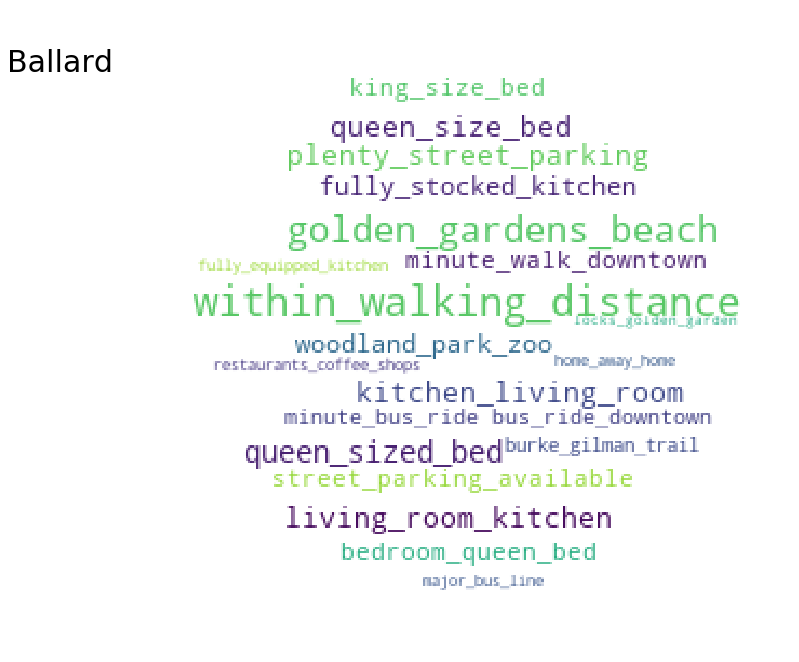

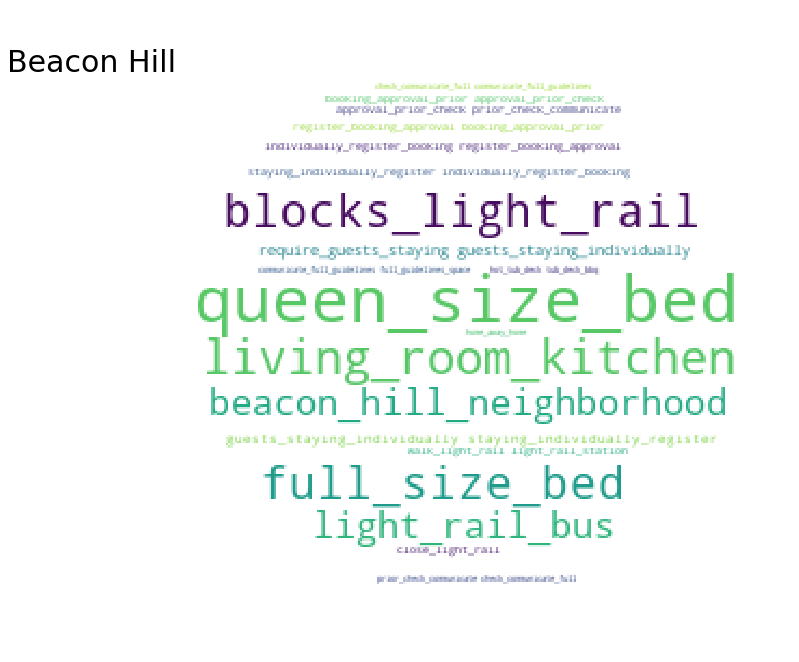

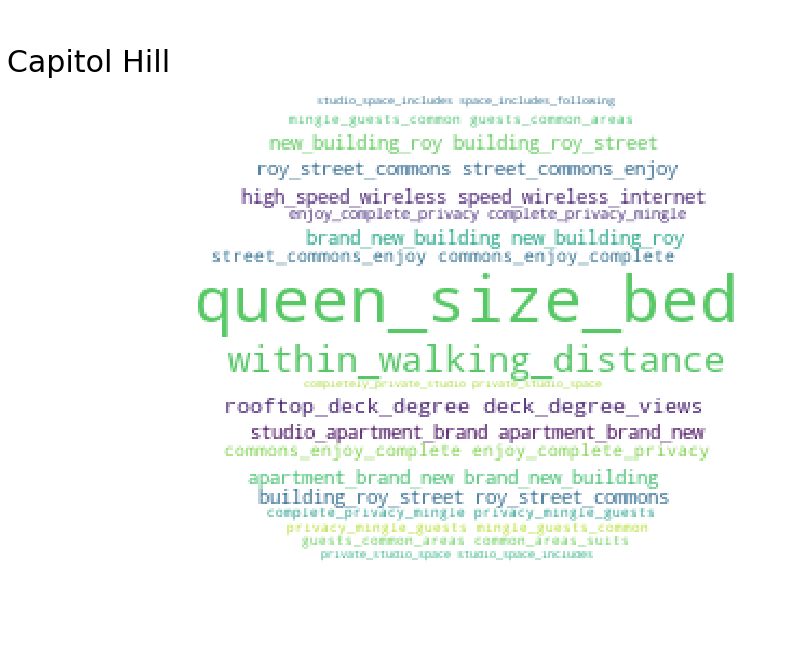

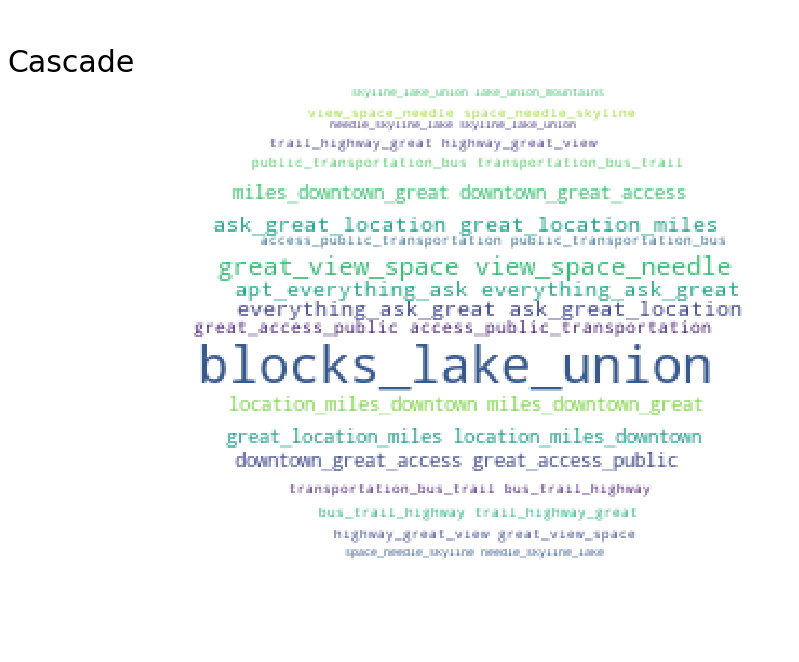

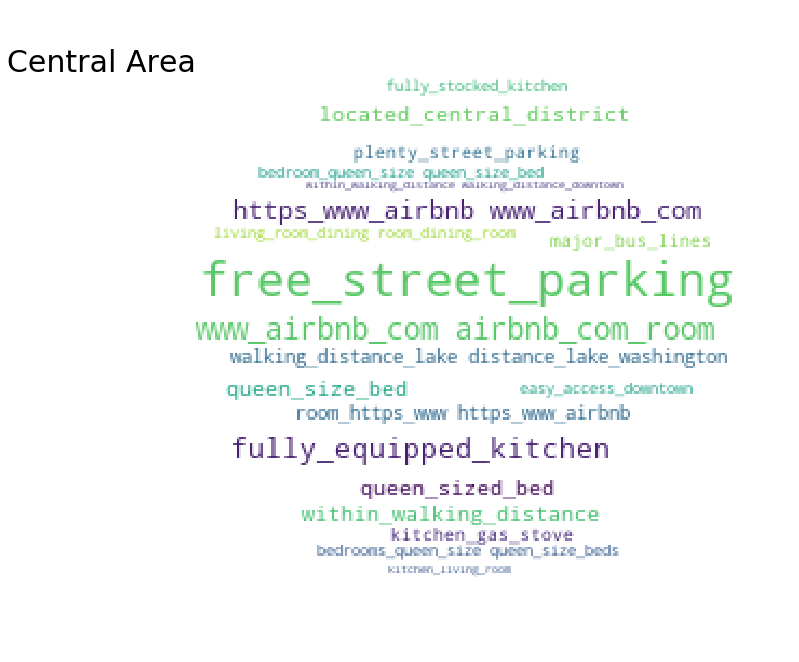

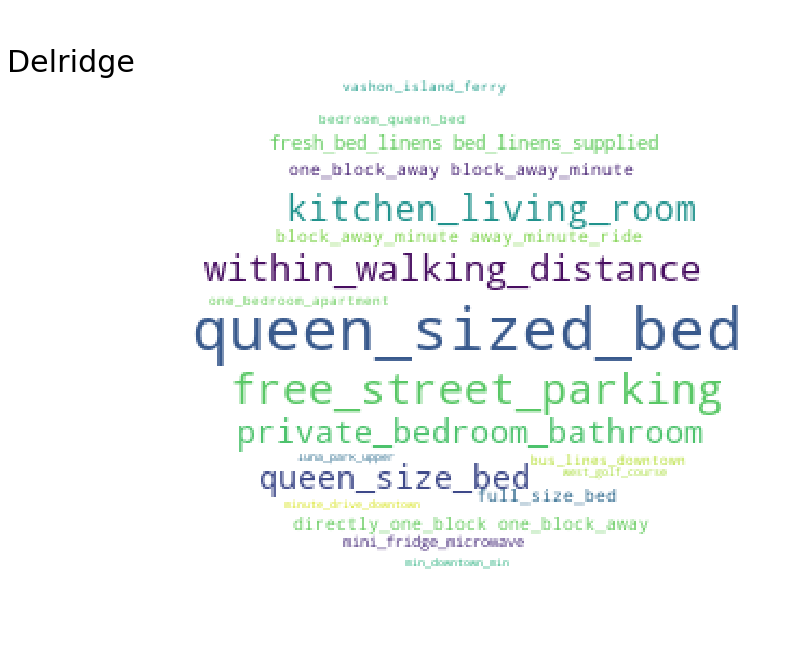

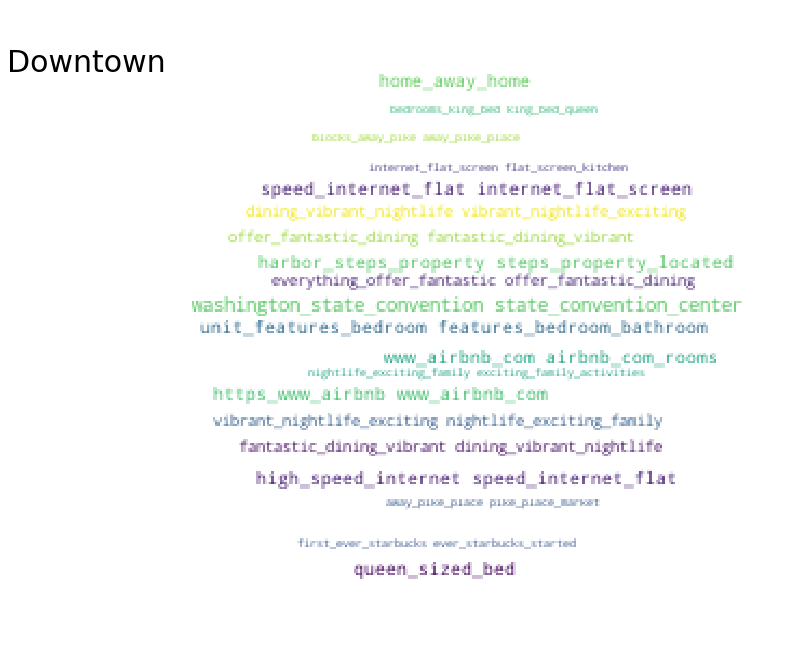

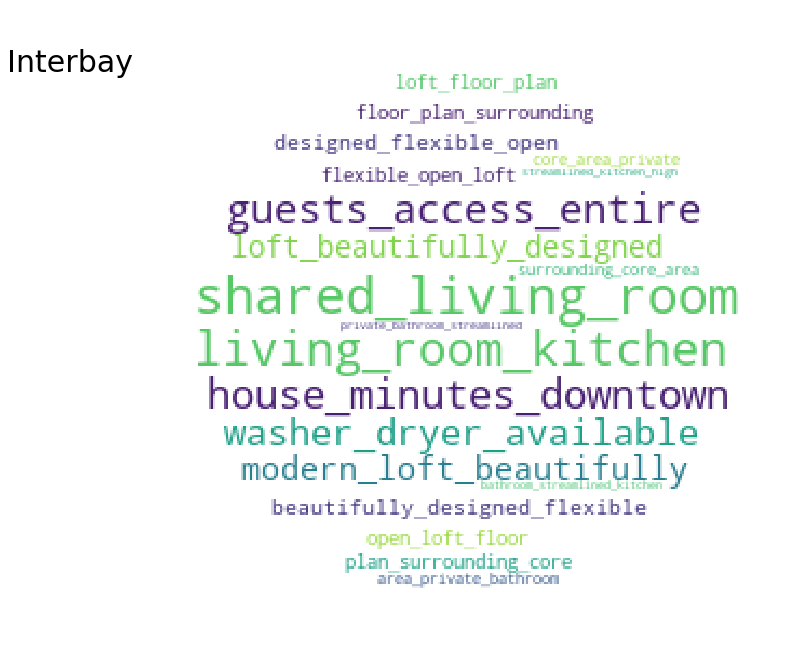

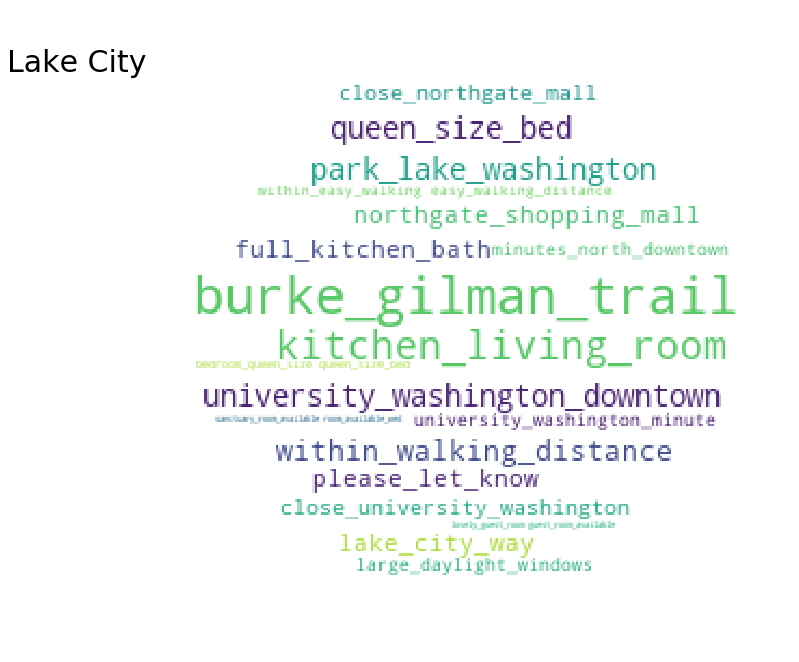

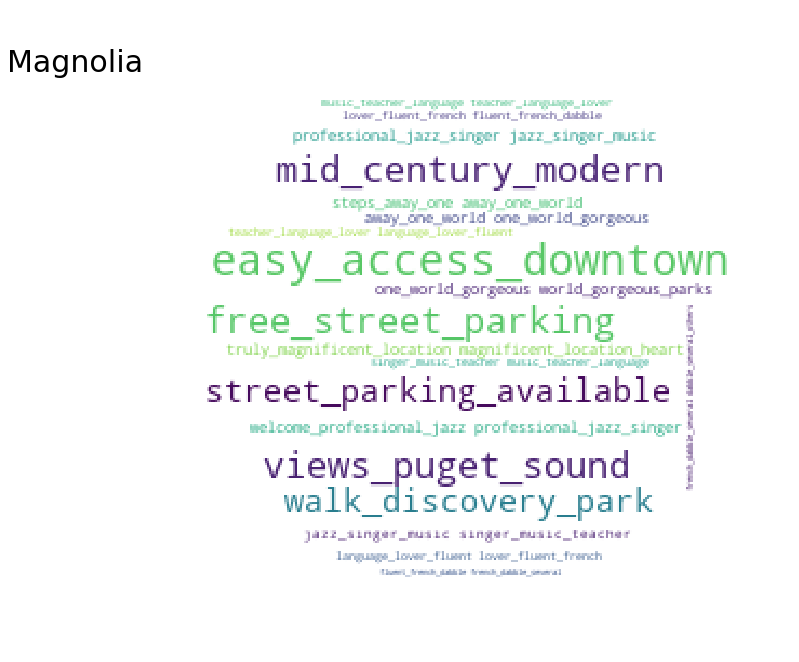

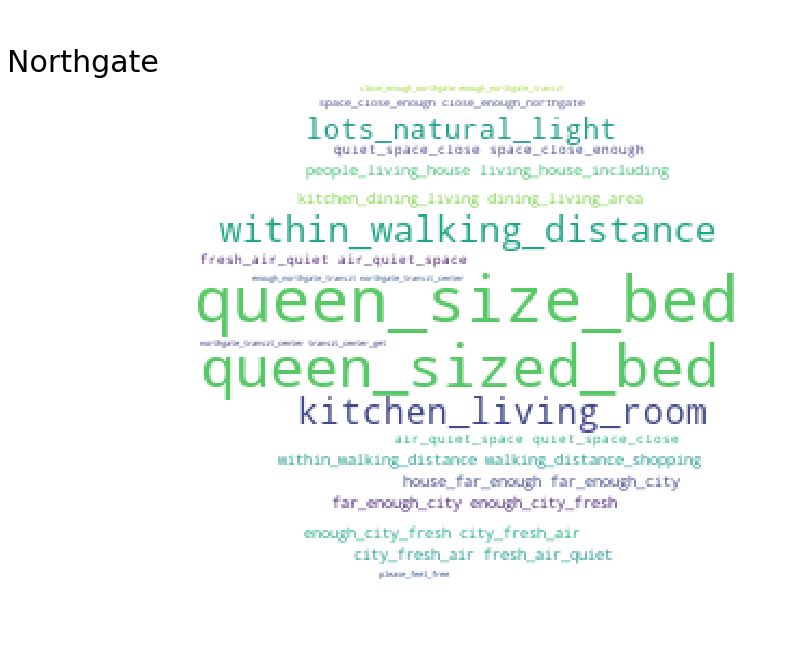

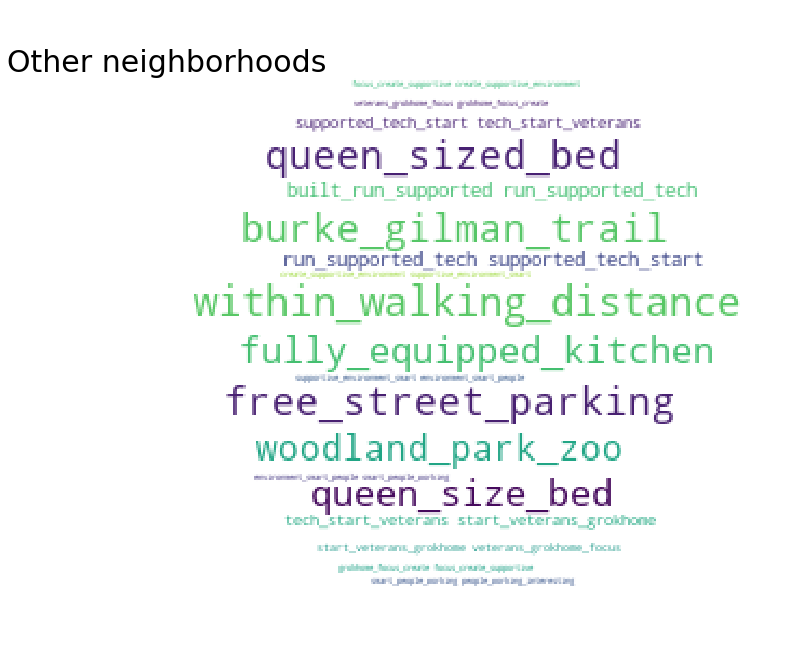

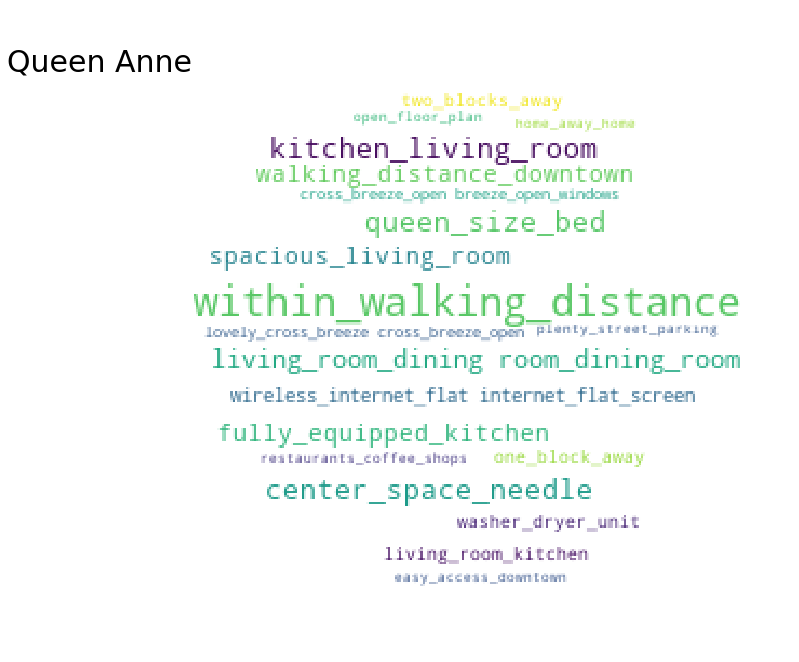

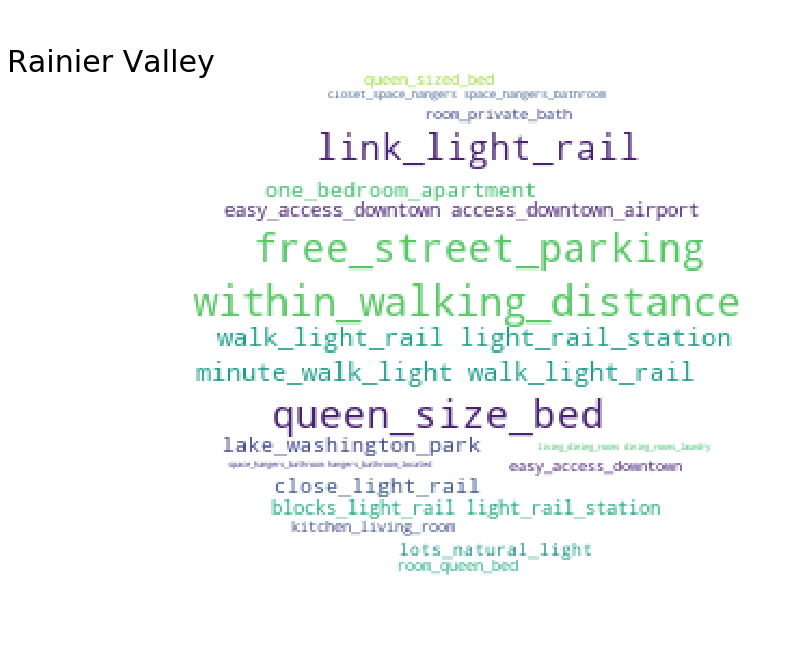

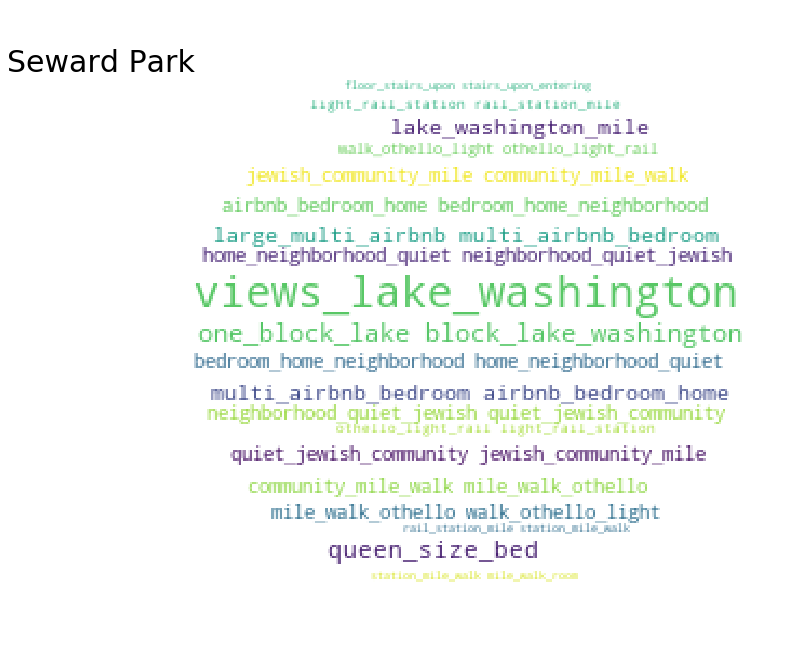

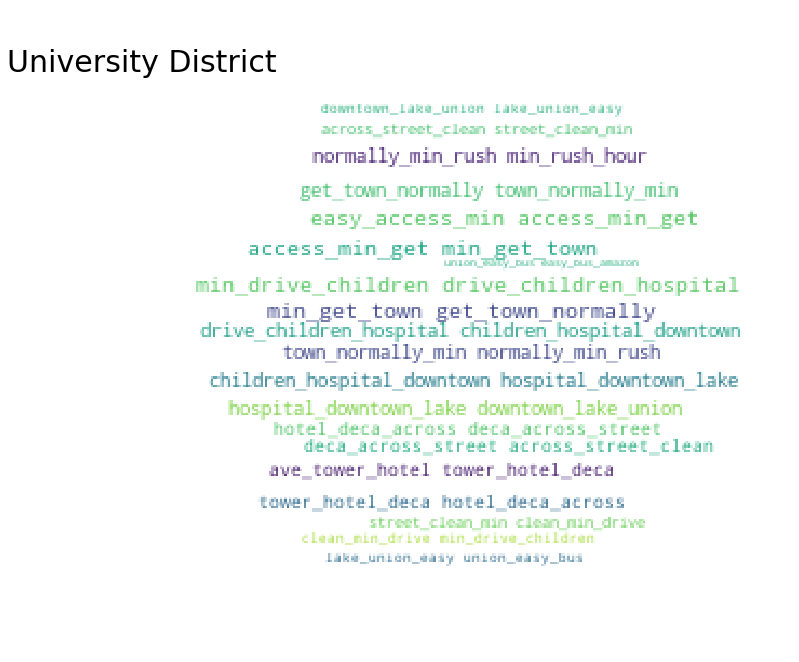

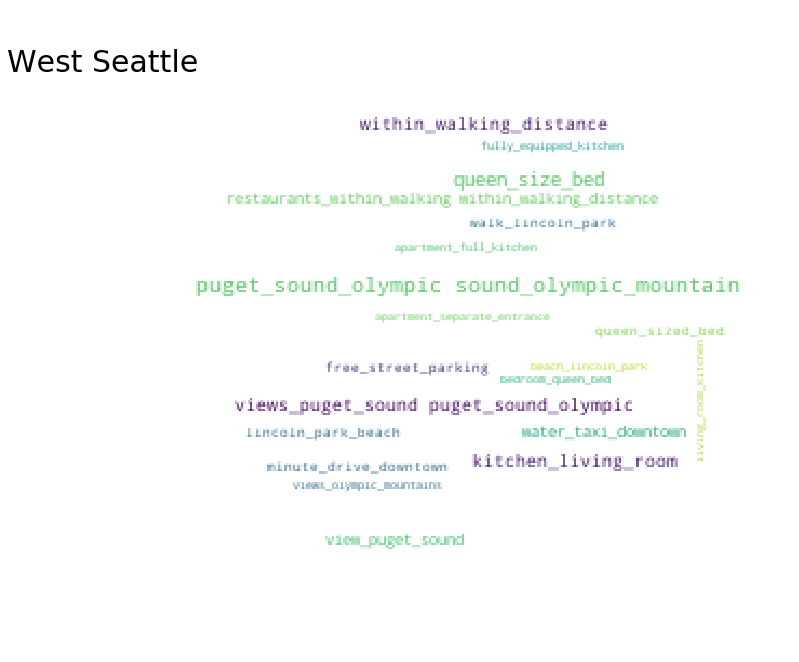

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

x, y = np.ogrid[:600, :600]

mask = (x - 300) ** 2 + (y - 300) ** 2 > 260 ** 2
mask = 510 * mask.astype(int)    

for neighbourhood, text in zip(nonull_neighbor_review['neighbourhood_group_cleansed'],
                nonull_neighbor_review['neighborhood_overview_description_clean_trigram_wordcloud']):

#     x, y = np.ogrid[:600, :600]

#     mask = (x - 300) ** 2 + (y - 300) ** 2 > 260 ** 2
#     mask = 510 * mask.astype(int)    

    
    
    wordcloud = WordCloud(background_color="white",mask =mask,
                          width=500, height=500, max_words=20, max_font_size=512,
               random_state=42).generate(text)
# Open a plot of the generated image.

    plt.figure( figsize = (16,9), facecolor='white')
    plt.figtext(0.1,0.9,neighbourhood,fontsize=30)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()